In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
#%matplotlib inline

In [4]:
import sys

In [5]:
sys.path.insert(1, "/home/gemeinl/code/braindecode_lazy/")

In [6]:
from examples.utils import read_network_results, df_list_from_dir, dfs_from_dir

In [26]:
# taken from https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [27]:
import matplotlib

In [28]:
matplotlib.rcParams["font.size"] = 20

In [29]:
sns.set(font_scale=1.5, palette="tab10")

In [30]:
def plot_learning_with_two_scales(df, ylim, ylim2, just_test=False,
                                  out_dir=None, ax=None, plot_axis_labels=False,
                                  plot_legend=False, plot_xlabel=False):
    if ax is None:
        fig, ax1 = plt.subplots(figsize=(20, 8))
    else:
        ax1 = ax
    misclass_or_rmse = "misclass" if "train_misclass" in df[0] else "rmse"
    if misclass_or_rmse == "rmse":
        factor = 1
        second_y_label = misclass_or_rmse + " [years]"
        second_y_lim = 0, ylim
    else:
        factor = 100
        second_y_label = misclass_or_rmse + " [%]"
        second_y_lim = 0, ylim
        
    test_loss_color = sns.color_palette()[1]
    test_loss_linestyle = "-"
    train_loss_color = sns.color_palette()[3]
    train_loss_linestyle = "-"

    if not just_test:
        for i in range(len(df)):
            ax1.plot(np.log(df[i].train_loss), color=train_loss_color, linewidth=.5, label="", linestyle=train_loss_linestyle)
    mean_loss = np.mean([df[i].train_loss for i in range(len(df))], axis=0)
    mean_loss_final = np.mean([df[i].train_loss.iloc[-1] for i in range(len(df))], axis=0)
    std_loss_final = np.std([df[i].train_loss.iloc[-1] for i in range(len(df))], axis=0)
    l1 = ax1.plot(np.log(mean_loss), color=train_loss_color, linestyle=train_loss_linestyle,
                  label="train loss")# ({:.2f} $\pm$ {:.2f})".format(mean_loss_final, std_loss_final))

    for i in range(len(df)):
        ax1.plot(np.log(df[i].test_loss),  color=test_loss_color, linewidth=.5, label="", linestyle=test_loss_linestyle)
    mean_loss = np.mean([df[i].test_loss for i in range(len(df))], axis=0)
    mean_loss_final = np.mean([df[i].test_loss.iloc[-1] for i in range(len(df))], axis=0)
    std_loss_final = np.std([df[i].test_loss.iloc[-1] for i in range(len(df))], axis=0)
    l2 = ax1.plot(np.log(mean_loss), color=test_loss_color, linestyle=test_loss_linestyle,
                  label="test loss")# ({:.2f} $\pm$ {:.2f})".format(mean_loss_final, std_loss_final))

    if plot_xlabel:
        ax1.set_xlabel('Epoch')
    # Make the y-axis label, ticks and tick labels match the line color.
    yaxis_color = [.5 * (sns.color_palette()[1][i] + sns.color_palette()[3][i]) for i in range(3)]
    if plot_axis_labels:
        ax1.set_ylabel('0.25 * log loss', color=yaxis_color, y=-.2)
    ymin = ylim2
    ymax = 0
    ax1.set_ylim(ymin, ymax)
    y_ticks = np.linspace(ymin, ymax, 6)
    ax1.set_yticks(y_ticks)
    #ax1.set_yticklabels(["{:.1f}".format(i) for i in y_ticks])
    ax1.set_yticklabels(range(-len(y_ticks)+1, 1))
    ax1.tick_params('y', colors=yaxis_color)

    # plot misclass
    test_misclass_color = sns.color_palette()[0]
    test_misclass_linestyle = "-"
    train_misclass_color = sns.color_palette()[2]
    train_misclass_linestyle = "-"
    
    # plot on second y axis
    ax2 = ax1.twinx()

    if not just_test:
        for i in range(len(df)):
            ax2.plot(df[i]["train_" + misclass_or_rmse] * factor, linestyle=train_misclass_linestyle, 
                     color=train_misclass_color, linewidth=.5, label="")
    mean_misclass = np.mean([df[i]["train_" + misclass_or_rmse] * factor for i in range(len(df))], axis=0)
    mean_misclass_final = np.mean([df[i]["train_" + misclass_or_rmse].iloc[-1] * factor for i in range(len(df))], axis=0)
    std_misclass_final = np.std([df[i]["train_" + misclass_or_rmse].iloc[-1] * factor for i in range(len(df))], axis=0)
    l3 = ax2.plot(mean_misclass, linestyle=train_misclass_linestyle, color=train_misclass_color,
                  label="train " + misclass_or_rmse)# + " ({:.2f} $\pm$ {:.2f})".format(mean_misclass_final, std_misclass_final))

    for i in range(len(df)):
        ax2.plot(df[i]["test_" + misclass_or_rmse] * factor, linestyle=test_misclass_linestyle,
                 color=test_misclass_color, linewidth=.5, label="")
    mean_misclass = np.mean([df[i]["test_" + misclass_or_rmse] * factor for i in range(len(df))], axis=0)
    mean_misclass_final = np.mean([df[i]["test_" + misclass_or_rmse].iloc[-1] * factor for i in range(len(df))], axis=0)
    std_misclass_final = np.std([df[i]["test_" + misclass_or_rmse].iloc[-1] * factor for i in range(len(df))], axis=0)
    l4 = ax2.plot(mean_misclass, linestyle=test_misclass_linestyle, color=test_misclass_color,
                  label="test " + misclass_or_rmse)# + " ({:.2f} $\pm$ {:.2f})".format(mean_misclass_final, std_misclass_final))

    yaxis2_color = [.5 * (sns.color_palette()[0][i] + sns.color_palette()[2][i]) for i in range(3)]
    if plot_axis_labels:
        ax2.set_ylabel(second_y_label, color=yaxis2_color, y=-.2)
    ax2.set_ylim(second_y_lim)
    ax2.set_xlim(0, df[-1].index[-1])
    ax2.set_yticks(np.linspace(0, ylim, 6))
    ax2.tick_params(axis='y', colors=yaxis2_color)
    
    if plot_legend:
        ls = l1 + l2 + l3 + l4
        labels = [l.get_label() for l in ls]
        # when using long legend labels (test_misclass, train_loss, ...) use this positioning
        ax2.legend(ls, labels, ncol=4, loc="upper right", framealpha=.75, bbox_to_anchor=(0.805, 1.33))
        # short label (train, test, ...) positioning
        #ax2.legend(ls, labels, ncol=4, loc="upper right", framealpha=.75, bbox_to_anchor=(0.705, 1.33))

    return ax

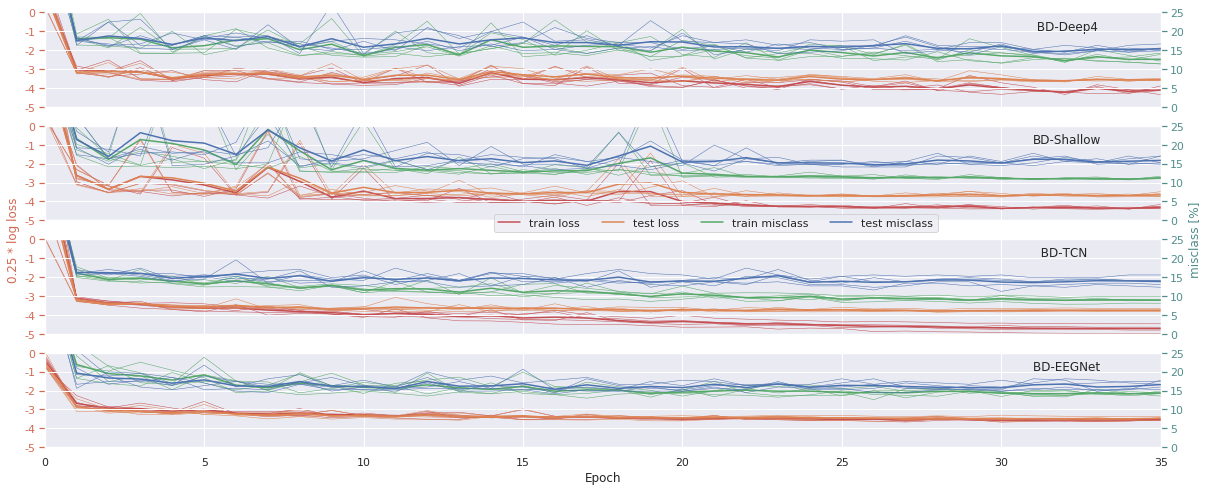

In [66]:
task = "pathological"
cv_or_eval = "eval"
models = [" BD-Deep4  ", "BD-Shallow", "  BD-TCN  ", "BD-EEGNet "]
fig, ax_arr = plt.subplots(nrows=len(models), ncols=1, sharex=True, sharey=True, figsize=(20,len(models)*2))
for i, model in enumerate(models):
    plot_legend = True if i == 2 else False
    plot_xlabel = True if i == 3 else False
    plot_axis_label = True if i == 1 else False
    
    df_list = df_list_from_dir("/home/gemeinl/results/all_recs_100_hz/networks/{}/{}/{}/".format(model.split("-")[-1].strip().lower()[:-1] if "4" in model else 
                                                                                                 model.split("-")[-1].strip().lower()
                                                                                                 , task, cv_or_eval))
    ax = plot_learning_with_two_scales(df_list, ylim=25, ylim2=-1.25, ax=ax_arr[i], 
                                       plot_legend=plot_legend, plot_xlabel=plot_xlabel, plot_axis_labels=plot_axis_label)
    ax.text(x=31, y=-.23, s=model)